<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step4a_initialize_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepPoseKit Step 4a - Initialize annotations

This is step 4a of the example notebooks for using DeepPoseKit. This notebook shows you how to use your trained model to initialize the keypoint labels for the unannotated images in your annotation set.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

**If you're using Colab**: make sure to go to the “Runtime” dropdown menu, select “Change runtime type” and select `GPU` in the "Hardware accelerator" drop-down menu


If you haven't already installed DeepPoseKit you can run the next cell

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
!{sys.executable} -m pip install -U deepposekit

     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for deepposekit: filename=deepposekit-0.3.9-cp36-none-any.whl size=105114 sha256=1f6c721351ee3afe47f6f613d68ac3a65ddfe3cbd250ff877c709706134d4d4c
  Stored in directory: /root/.cache/pip/wheels/63/92/3e/96682d235db0100cb3f86a8ddd677756a22fd04f0ee1fe3936
Successfully built deepposekit


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, ImageGenerator

from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
    HOME = '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom'
    video_file_path = '/human/'
    video_file_name = 'pose_human_test.mp4'
        
except:
    IN_COLAB = False
    HOME = 'E:\\Work\\github repos\\deepposekit_data_custom'
    video_file_path = '\\human\\'
    video_file_name = 'pose_human_test.mp4'

#HOME = expanduser("~") if not IN_COLAB else '.'

Use the next cell to download the example data into your home directory

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

fatal: destination path 'C:\Users\Advait/deepposekit-data' already exists and is not an empty directory.


Find the saved models

In [ ]:
HOME + video_file_path

'/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/'

In [ ]:
import os
os.listdir(HOME + video_file_path)

['skeleton.csv',
 'pose_human_test.mp4',
 'example_annotation_set.h5',
 'best_model_densenet.h5']

In [ ]:
models = sorted(glob.glob(HOME + video_file_path + '*model*.h5'))
models

['/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/best_model_densenet.h5']

Find the annotation sets

In [ ]:
annotations = sorted(glob.glob(HOME + video_file_path + '*annotation*.h5'))
annotations

['/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/example_annotation_set.h5']

# Load the trained model

This loads the trained model into memory for making predictions

In [ ]:
model = load_model(HOME + video_file_path + 'best_model_densenet.h5')

# Initialize unannotated data

This creates a `DataGenerator` instance for loading the data, which is then wrapped in an `ImageGenerator`. `ImageGenerator` is then passed to the model for initializing the unannotated keypoints with predictions from a previously-trained model the image data. See the doc string for details:

In [ ]:
DataGenerator?

In [ ]:
ImageGenerator?

Let's initialize our `example_annotation_set.h5` from Step 1

In [ ]:
data_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set.h5', mode='unannotated')
image_generator = ImageGenerator(data_generator)

/usr/local/lib/python3.6/dist-packages/deepposekit/io/DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


This passes the data generator to the model to get the predicted coordinates

In [ ]:
predictions = model.predict(image_generator, verbose=1)

8/8 [==============================] - 7s 591ms/step


In [ ]:
predictions.shape

(8, 7, 3)

This saves the predicted coordinates as initial keypoint locations for the unannotated data

In [ ]:
data_generator[:] = predictions

Indexing the generator, e.g. `data_generator[0]` returns an image-keypoints pair, which you can then visualize. 

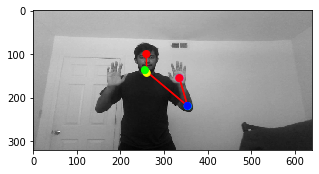

In [ ]:
image, keypoints = data_generator[4]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()